In [1]:
### Import libraries and set plot style

import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.transforms as trans
colors = ['#202020', '#d62728', '#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd', '#bcbd22', '#e377c2', '#17becf', '#1f5a0a', '#8c564b', '#7f7f7f']
         ## black    red        blue       green      orange     violet     yellow     pink       lightblue  darkgreen  dirty-red  grey
plt.rcParams.update({'font.size': 7,
                     'axes.labelpad': 5,
                     'axes.labelsize': 8,
                     'xtick.labelsize' : 7,
                     'ytick.labelsize' : 7,
                     'axes.prop_cycle': cycler('color', colors),
                     #'axes.grid': True,
                     'axes.linewidth': 0.5,
                     'lines.linewidth': 0.5,
                     'lines.markersize': 2,
                     'scatter.marker': 'o',
                     #'errorbar.capsize': 2,
                     'figure.dpi': 100.0,
                     'figure.figsize': [5, 3],
                     'xtick.top' : True,
                     'ytick.right' : True,
                     'xtick.direction' : 'out',
                     'ytick.direction' : 'out',
                     'xtick.major.size': 2,
                     'xtick.minor.size': 1,
                     'ytick.major.size': 2,
                     'ytick.minor.size': 1,
                     'xtick.major.width': 0.5,
                     'xtick.minor.width': 0.2,
                     'ytick.major.width': 0.5,
                     'ytick.minor.width': 0.2})

In [2]:
### Import raw data and define measurement specifications

SAMPLE = "20 wt.% PEI"
SAMPLE_SHORT = SAMPLE[:2]
# specify what temperatures where used and in what order
TEMPS = [70, 50, 30]
GASES = ["N$_2$", "CO$_2$"]
# specify which gas is used in which run: N_2 -> 0, CO_2 -> 1 (specified in "GASES")
# rows: measurements with fixed temperature, same order as "TEMPS" above
# columns: runs
# (compatability) the same gas may be used twice in a row
S = [[1, 0, 1, 0],
     [1, 0, 1, 0],
     [0, 1, 0, 1, 0]]
# specify the starting times of the runs
# sometimes the measurement doesn't start at t=0: set GASCHANGE[0] to cut out degassing phase, otherwise set 0 as first value
# After that, put time in seconds for every time the gas is changed (or new ballon with same gas)
GASCHANGE = [[0, 6989, 16205, 25988],
             [1.8848e+04, 19289, 25645, 33843],
             [7.0136e+03, 10697, 18196, 25623, 32600]]
# columns (indices) of frequency, epsilon' (er), epsilon'' (ei) and time in ascii file
f_col, er_col, ei_col, t_col = 0, 2, 3, -1

# specify folder and filenames of raw data, files in same order as "TEMPS" above
folder = "raw data PEI20/"
files = ["13-10_M2_TBD031_PEI20_70C_CNCN.TXT",
         "13-13_M1_TBD031_PEI20_50C_NdryCNCN.TXT",
         "13-14_M2_TBD031_PEI20_30C_NdryCNCN.TXT"]
DATA = [[], [], []]

for m, f in enumerate(files) :
     # import ascii data, usually it has a header of 4 lines that is cut out
     data_ = np.genfromtxt(folder+f, delimiter='\t', skip_header=4)

     # remove points before start of first run
     after = data_[:,-1] >= GASCHANGE[m][0]
     data = data_[after]

     # add final time to GASCHANGE, needed in main and make time unit hours
     GASCHANGE[m].append(data[-1,-1])
     GASCHANGE[m] = np.array(GASCHANGE[m]) / 60.
     data[:,-1] = data[:,-1] / 60.

     DATA[m] = data

In [3]:
### Data processing


def gradient_matrix(y, x) :
    # y is a 2D array of shape (m,n) and x a vector of shape m
    # froms forward gradient of every column of y along x
    # returns matrix of shape (m-1,n)
    return (y[1:, :] - y[:-1, :]) / (x[1:] - x[:-1])[:, np.newaxis]

f_out = [5e5]
def extract_interpolate_and_derivative(data, num_points=1000):
    """
    Extracts lists x_k for every measured data x at a fixed frequency k
    Creates a universal test set of time points
    Interpolates every fixed-frequency data set for those time points
    Computes derivative epsilon'_der along frequency axis
    """
    
    # Extract unique F_k values
    # ignore frequencies specified in f_out
    unique_f = np.unique(data[:, f_col])
    mask = ~np.isin(unique_f, f_out)
    unique_f = unique_f[mask]
    lnw = np.log(2*np.pi*unique_f)  # Compute ln(omega)
    lnw_der = (lnw[:-1] + lnw[1:])/2
    
    # find time boundaries of data
    # and generate `num_points` equidistant t_i values
    initial_test_t, final_test_t = -np.inf, np.inf
    for k, f_k in enumerate(unique_f) :
        mask = data[:, 0] == f_k
        t_k = data[mask][:, t_col]
        initial_test_t = max(initial_test_t, np.min(t_k))
        final_test_t = min(final_test_t, np.max(t_k))
    if not num_points:
        num_points = int((final_test_t - initial_test_t) *2)
        
    t_test_set = np.linspace(initial_test_t, final_test_t, num_points)

    # er: real part of epsilon; ei: imag. part; t: corresponding measured time
    t_raw, er_int, er_raw = [], [], []
    # Group er_k and ei_k based on unique F_k
    # unify to test times by interpolation
    for f_k in unique_f:
        mask = data[:, 0] == f_k
        t_k = data[mask][:, t_col]
        er_k = data[mask][:, er_col]
        
        interpolator_er_k = interp1d(t_k, er_k, kind='linear', bounds_error=False, fill_value=np.nan)

        er_int.append(interpolator_er_k(t_test_set))
        er_raw.append(er_k)
        t_raw.append(t_k)

    t_raw = np.array(t_raw)
    er_int = np.array(er_int)
    er_raw = np.array(er_raw)


    # Compute gradient of er_k along ln(F)
    er_der_int =  -np.pi/2 * gradient_matrix(er_int, lnw)
    er_der_raw =  -np.pi/2 * gradient_matrix(er_raw, lnw)

    return np.exp(lnw_der), er_der_raw.T, t_raw, er_der_int.T, t_test_set

def round_sig(x, n):
    if x == 0:
        return 0
    return float(round(x, n - int(__import__('math').floor(__import__('math').log10(abs(x)))) - 1))

def exps(x, a, b, c, d, e) :
    return np.exp(-b*(x-a)) + c - np.exp(-d*(x-e))
def expp(x, a, b, c) :
    return np.exp(-b*(x-a)) + c
def expn(x, c, d, e) :
    return c - np.exp(-d*(x-e))

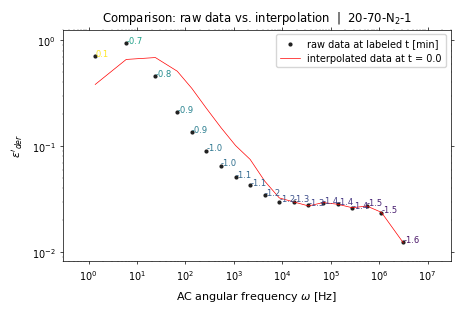

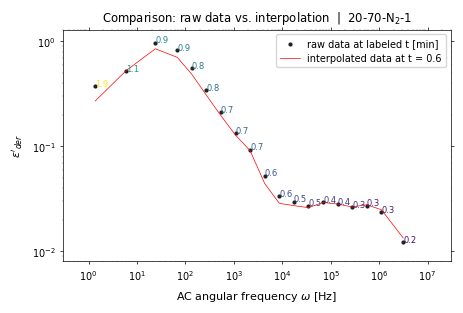

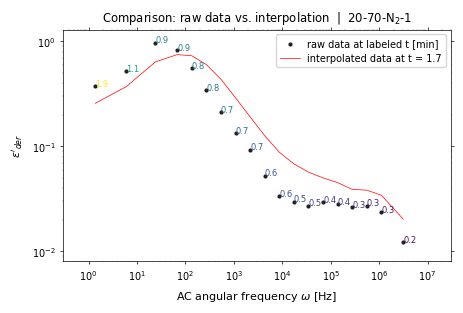

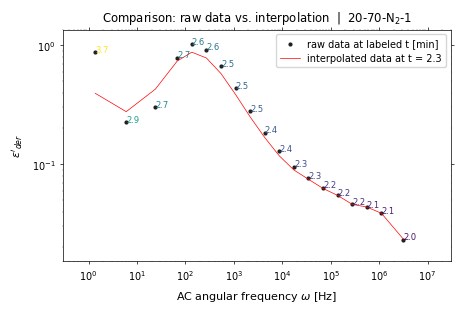

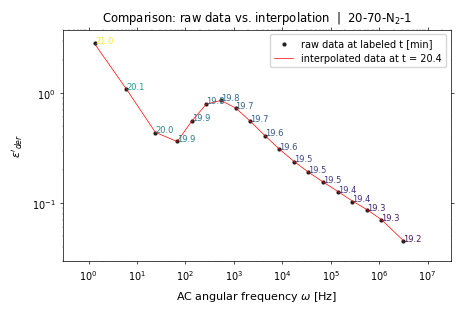

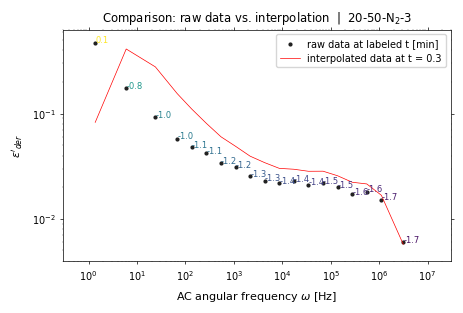

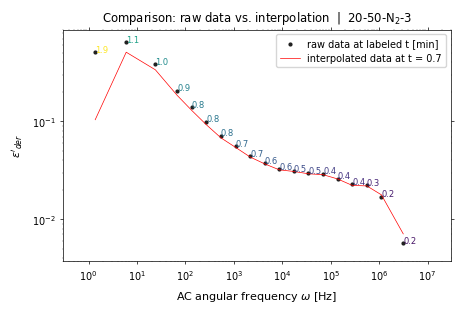

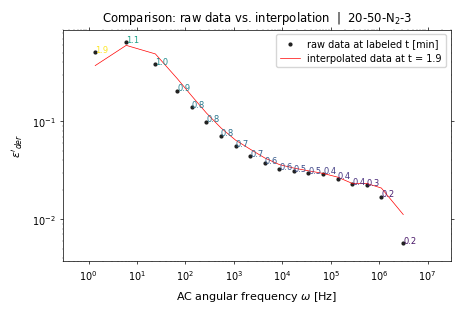

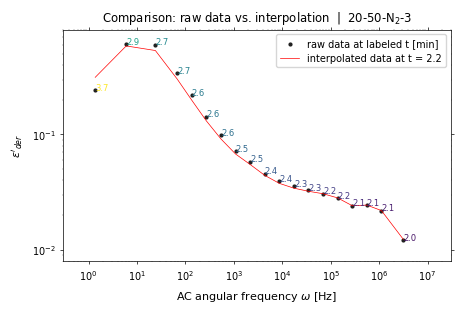

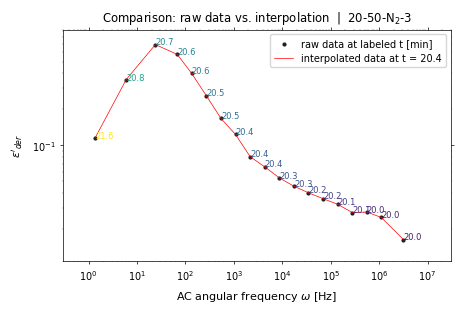

In [4]:
### main

title_text = "Comparison: raw data vs. interpolation  |  "

ID = []
# show runs
id_choose = ["70-1", "50-3"]
# selection of a few indices where the plot is shown; quadratic: show many at the start and less later
plottimes = [0, 0.5, 1.7, 2, 20]
tol = 5


# go throgh all temperatures, or rather their respective datasets
for m, data in enumerate(DATA) :
    temp = str(TEMPS[m])

    # f is an array of the unique frequencies
    # er_der is a 2D array of all "numerical derivative of real part"-values
    # er_der[i] (one row of the matrix) is one spectrum
    # where i (one column) corresponds to the time
    # The array contains a whole measurement with fixed temperature and all gas runs
    w, er_der_raw, t_raw, er_der_int, t_int = extract_interpolate_and_derivative(data)
    
    # go throgh all runs, one run starts with change of gas
    for j, t0 in enumerate(GASCHANGE[m][:-1]) :
        if temp+'-'+str(j) not in id_choose :
            continue
        gas = GASES[S[m][j]]
        ID.append(temp+'-'+gas+'-'+str(j))
        run_num = len(ID) - 1

        t1 = GASCHANGE[m][j+1]-tol

        for plot_t in plottimes :
            # indices of start/end of current run
            plot_int_i = np.searchsorted(t_int, t0+plot_t, side="left")
            plot_i = np.searchsorted(t_raw[0], t0+plot_t, side="left")

            dt_int = np.round(t_int[plot_int_i]-t0,1)
            dt = t_raw[0][plot_i]-t0


            plt.xscale('log')
            plt.yscale('log')
            plt.scatter(w, er_der_raw[plot_i], label="raw data at labeled t [min]")
            plt.plot(w, er_der_int[plot_int_i], color = 'red', label="interpolated data at t = " + str(dt_int))
            plt.ylim(np.min(er_der_raw[plot_i])*2/3, np.max(er_der_raw[plot_i])*4/3)
            plt.xlim(3e-1, 3e7)
            
            t_raw_0, t_raw_n = np.min(t_raw[:,plot_i]), np.max(t_raw[:,plot_i])
            for i in range (len(er_der_raw[plot_i])) :
                color = plt.cm.viridis((t_raw[i][plot_i] - t_raw_0) / (t_raw_n - t_raw_0))
                time = np.round(t_raw[i][plot_i] - t0,1)
                plt.text(w[i], er_der_raw[plot_i][i], str(time), color=color, fontsize=6)
                plt.ylabel("$\\epsilon'_{der}$") # = -\\frac{\\pi}{2} ~ \\frac{\\partial\\epsilon'}{\\partial\\ln(\\omega)}

            title = title_text + SAMPLE_SHORT +"-"+ ID[-1]
            plt.title(title)
            plt.xlabel("AC angular frequency $\omega$ [Hz]")

            plt.legend()
            #plt.savefig("specevo/"+ID[-1]+".png", bbox_inches='tight')
            plt.show()